# Code for Cplex formulation of Alstom problem

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from docplex.mp.basic import Expr
from docplex.mp.model import Model
from docplex.mp.solution import SolveSolution
from docplex.util.status import JobSolveStatus
import cplex.callbacks as cpx_cb

## Approximating the functions with polynomials

### RAV function

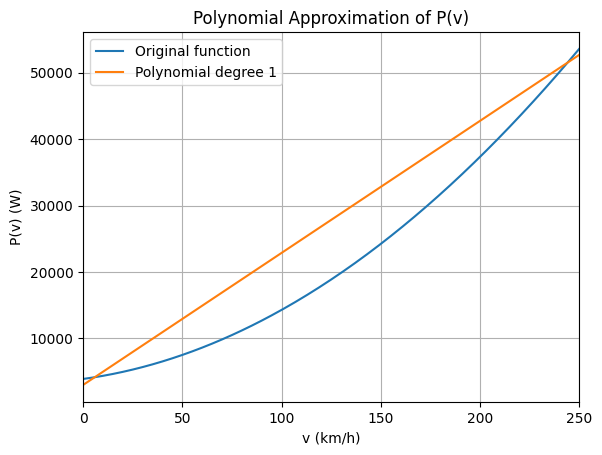

[ 198.7 3000. ]


In [2]:
A, B, C, m, v_max, p_max, c_max = 3900, 40.7, 0.632, 400000, 220, 4305220, 320000
import numpy as np


def P(v):
    return (A + B * v + C * v**2)


a, b = 0, 250
n = 1

# Choose n+1 interpolation points
x_points = np.linspace(a, b, 251)
y_points_bis = []
for x in x_points:
    y_points_bis.append(P(x))

# Get the polynomial coefficients (highest degree first)
coeffs_rav = np.polyfit(x_points, y_points_bis, deg=n)
coeffs_rav[1] = 3000
# Create polynomial function
Prav_poly = np.poly1d(coeffs_rav)


def Prav(v):
    return Prav_poly(v)
# Remove RAV to simplify the problem
'''def Prav(v):
    return 0'''

y_points_approx = []
for i in range(len(x_points)):
    y_points_approx.append(Prav(x_points[i]))


if __name__ == "__main__":
    plt.plot(x_points, y_points_bis, label="Original function")
    plt.plot(x_points, y_points_approx, label=f"Polynomial degree {n}")
    plt.title("Polynomial Approximation of P(v)")
    plt.xlabel("v (km/h)")
    plt.ylabel("P(v) (W)")
    plt.xlim(a, b)
    plt.legend()
    plt.grid(True)
    plt.show()

print(coeffs_rav)

### Traction

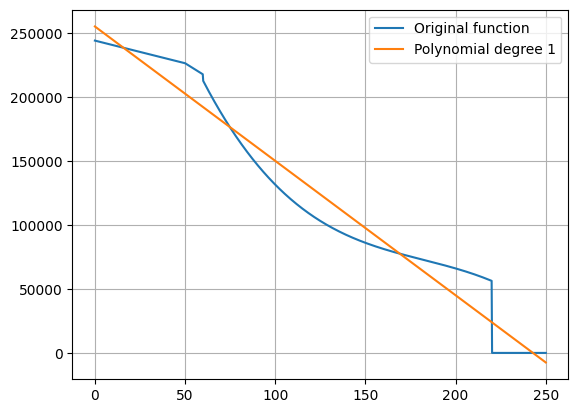

In [3]:
def f(v):
    if 0 <= v <= 50:
        return -354.1 * v + 2.44 * (10**5)
    elif 50 <= v < 60:
        return -881.3 * v + 2.704 * (10**5)
    elif 60 <= v < 220:
        return -0.05265 * (v**3) + 28.78 * (v**2) - 5603 * v + 4.566 * (10**5)
    else:
        return 0
    
a, b = 0, 250
n = 1

# Choose n+1 interpolation points
x_points = np.linspace(a, b, 1000)
y_points_bis = []
for x in x_points:
    y_points_bis.append(f(x))

# Get the polynomial coefficients (highest degree first)
coeffs = np.polyfit(x_points, y_points_bis, deg=n)
# Create polynomial function
Ptraction = np.poly1d(coeffs)


y_points_approx = []
for i in range(len(x_points)):
    y_points_approx.append(Ptraction(x_points[i]))

F_pos_max = max(y_points_approx)

if __name__ == "__main__":
    plt.plot(x_points, y_points_bis, label="Original function")
    plt.plot(x_points, y_points_approx, label=f"Polynomial degree {n}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Braking

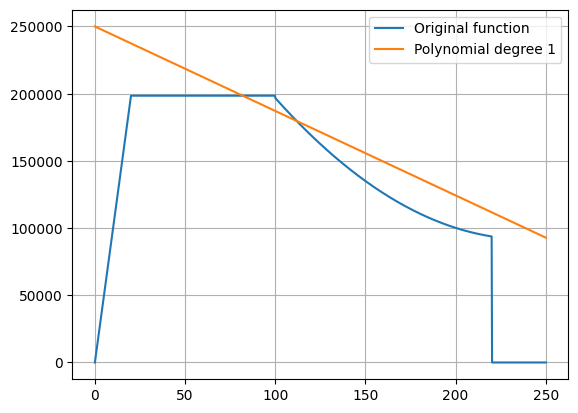

In [4]:
def f(v):
    if 0 <= v <= 20:
        return 9925 * v + 1.243
    if 20 <= v <= 100:
        return 2.039 * (10**-13) * v + 1.985 * (10**5)
    if 100 <= v <= 220:
        return 5.389 * (v**2) - 2583 * v + 4.012 * (10**5)
    else:
        return 0


# Interval [a, b] and degree n
a, b = 0, 250
n = 1

# Choose n+1 interpolation points
x_points = np.linspace(a, b, 1000)
y_points_bis = []
for x in x_points:
    y_points_bis.append(f(x))

# Get the polynomial coefficients (highest degree first)
coeffs = np.polyfit(x_points, y_points_bis, deg=n)
coeffs[1] = 250000
# Create polynomial function
Pbraking = np.poly1d(coeffs)



y_points_approx = []
for i in range(len(x_points)):
    y_points_approx.append(Pbraking(x_points[i]))

F_neg_max = max(y_points_approx)
F_max = max(F_pos_max, F_neg_max)

if __name__ == "__main__":
    plt.plot(x_points, y_points_bis, label="Original function")
    plt.plot(x_points, y_points_approx, label=f"Polynomial degree {n}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Power usage

[ 2.63310719e-14  7.13384433e-01 -3.18207202e-17  2.46745051e-02]
The polynomial is: 2.6331071925250774e-14 + 0.7133844326802611*x + -3.1820720205437547e-17*y + 0.024674505091038954*x*y


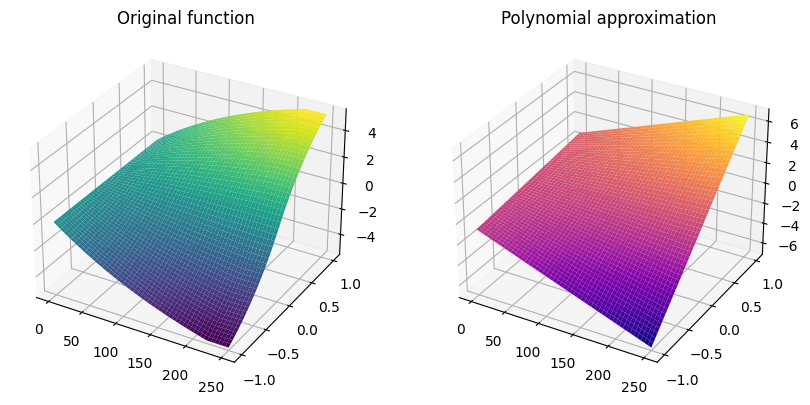

In [5]:
def cost(V, demand):
    F_max = 1
    V_max = 220
    F = demand
    p_max = 4305220
    c_max = 320000
    V_safe = min(V, V_max)
    # Ensure V is within a safe range for math.exp
    c = (
        (1 - math.exp(-V_safe / (V_max + 0.001)))
        * math.tanh(100 * F)
        * (1 - math.exp(-abs(F) / (F_max + 0.001)))
    )
    Puti = (c / c_max) * p_max
    # For now we ignore regen braking
    '''if Puti < 0:
        Puti = 0
    elif Puti > p_max:
        Puti = p_max'''
    return Puti


# Define the domain
a_x, b_x = 0, 250
a_y, b_y = -1, 1
n = 1  # degree in x
l = 1  # degree in y

# Create the interpolation points (equally spaced)
x_points = np.linspace(a_x, b_x, 1000)
y_points = np.linspace(a_y, b_y, 1000)
X, Y = np.meshgrid(x_points, y_points, indexing="ij")
Z = np.eye(1000)
for i in range(len(x_points)):
    for j in range(len(y_points)):
        x = x_points[i]
        y = y_points[j]
        Z[i, j] = cost(x, y)


# Build the Vandermonde matrix for 2D
x_flat = X.ravel()
y_flat = Y.ravel()

A = np.vstack([(x_flat**i) * (y_flat**j) for i in range(n + 1) for j in range(l + 1)]).T

b = Z.ravel()
coeffs_pow, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
print(coeffs_pow)
print(f"The polynomial is: {coeffs_pow[0]} + {coeffs_pow[1]}*x + {coeffs_pow[2]}*y + {coeffs_pow[3]}*x*y")


# Define the polynomial function
def Ppower(x, y):
    val = 0
    idx = 0
    for i in range(n + 1):
        for j in range(l + 1):
            val += coeffs_pow[idx] * (x**i) * (y**j)
            idx += 1
    return val


# Evaluation grid
x_eval = x_points
y_eval = y_points
X_eval, Y_eval = np.meshgrid(x_eval, y_eval, indexing="ij")
Z_eval = Ppower(X_eval, Y_eval)

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(X_eval, Y_eval, Z, cmap="viridis")
ax.set_title("Original function")

ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(X_eval, Y_eval, Z_eval, cmap="plasma")
ax2.set_title("Polynomial approximation")

plt.show()

Text(0.5, 1.0, 'Max acceleration at constant power vs Speed')

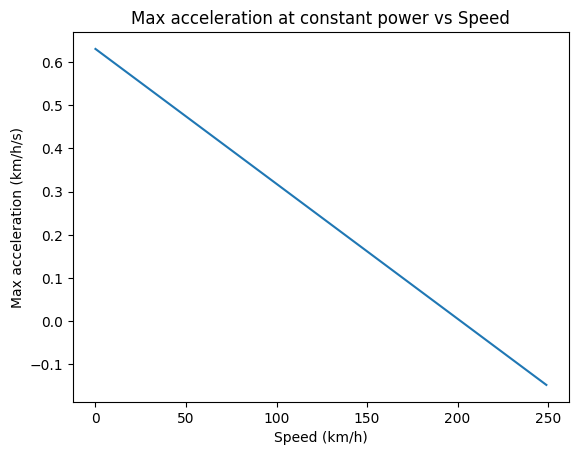

In [6]:
# Testing speed at constant maximum power
v = np.arange(0, 250, 1)
max_acceration = []
for speed in v:
    acc = (Ptraction(speed)-Prav_poly(speed)) / m
    max_acceration.append(acc)


plt.plot(v, max_acceration, label="Max acceleration at constant power")
plt.xlabel("Speed (km/h)")
plt.ylabel("Max acceleration (km/h/s)")
plt.title("Max acceleration at constant power vs Speed")

## Defining the Model

### Define model

In [7]:
opt_model = Model(name="Poly_Model")
N = 10
Dist = 0.05 #km
dt = 6 #seconds

### Define variables

In [8]:
v={}
for i in range(0, N):
    v[i]= opt_model.continuous_var(name=f"v_{i}",lb=0, ub=v_max)

## original formulation d is bound between -1 and 1
# d={}
# for i in range(0, N):
#     d[i]= opt_model.continuous_var(name=f"d_{i}",lb=-1, ub=1)


## new formulation c is bound between 0 and 2 where c[i] = d[i]-1

c={}
for i in range(0, N):
    c[i]= opt_model.continuous_var(name=f"c_{i}",lb=0, ub=2)

opt_model.add_constraint(c[0]>=1.0)

docplex.mp.LinearConstraint[](c_0,GE,1.0)

### Cost function

#### Linearization

In [9]:
# Here we linearize the D*v part of the polynomial approximation of our cost function

## we define w1 a variable which is w1 = c*v in old notation it was (d-1)*v 

### you defined d_min, d_max = -1, 1 which was wrong it should be 0,2
### you have to define limits carefully

w1 = {}
for i in range(0, N):
    # w1[i] = opt_model.continuous_var(name=f"w1_{i}",lb=0,ub=v_max)
    w1[i] = opt_model.continuous_var(name=f"w1_{i}",lb=0,ub=2*v_max)

V_min, V_max = 0, 250
# d_min, d_max = -1, 1
d_min, d_max = 0, 2

# coefficients from polynomial fit of cost function (Power consumption)
c0, c1, c2, c3 = coeffs_pow

# for i in range(0, N):
#     opt_model.add_constraint(w1[i] >= d_min*v[i] + (c[i])* V_min - V_min * d_min)
#     opt_model.add_constraint(w1[i] >= d_max*v[i] + (c[i])* V_max - V_max * d_max)
#     opt_model.add_constraint(w1[i] <= d_max*v[i] + (c[i])* V_min - d_max * V_min)
#     opt_model.add_constraint(w1[i] <= d_min*v[i] + (c[i])* V_max - d_min * V_max)

for i in range(0, N):
    # opt_model.add_constraint(w1[i] >= d_min*v[i] + (c[i])* V_min - V_min * d_min)
    opt_model.add_constraint(w1[i] >= d_max*v[i] + (c[i])* V_max - V_max * d_max)
    opt_model.add_constraint(w1[i] <= d_max*v[i])
    opt_model.add_constraint(w1[i] <=  (c[i])* V_max)

#### Definition

In [10]:
# Total cost

# it used to be c0 + c1 * v[i] + c2 * d[i] + c3 * w1[i] where w1[i] = d*V  
# but now in terms of c where W =c*v, we have new cost function c0 + c1 * v[i] + c2 * (c[i]-1) + c3 * (c-1)*v
# which is equal to c0 + c1 * v[i] + c2 * (c[i]-1) + c3*w1[i]- v



total_cost = opt_model.sum(c0 + c1 * v[i] + c2 * (c[i]-1) + (c3 * w1[i]) - v[i] for i in range(N))
opt_model.minimize(total_cost)

### Speed physics constraints (there is a problem somewhere in here)

#### Linearising

In [11]:
# Here we define the delta variables which are binary variables indicating whether we are acceleration or braking (ie. d>1 or d<1)
delta={}
for i in range(0, N):
    delta[i]= opt_model.binary_var(name=f"delta_{i}")

Big_M = 2
epsilon = 1e-9


for i in range(0, N):
    opt_model.add_constraint((c[i]-1) >= epsilon - Big_M * (1 - delta[i]))
    opt_model.add_constraint((c[i]-1) <= Big_M * delta[i])

In [12]:
# Here we define and linearize z1=delta*F_traction and z2=(1-delta)*F_braking
z1={}
z2={}
for i in range(0, N):
    z1[i]= opt_model.continuous_var(name=f"z1_{i}",lb=0,ub=F_max)
    z2[i]= opt_model.continuous_var(name=f"z2_{i}",lb=0,ub=F_max)

L1 = 0.0
L2 = 0.0
U1 = F_max
U2 = F_max


# for i in range(0, N):
#     opt_model.add_constraint(z1[i] <= delta[i]*U1)
#     opt_model.add_constraint(z2[i] <= (1 - delta[i]) * U2)

#     opt_model.add_constraint(z1[i] >= L1 * delta[i])
#     opt_model.add_constraint(z2[i] >= L2 * (1 - delta[i]))

#     opt_model.add_constraint(z1[i] <= Ptraction(v[i]) -L1*(1 - delta[i]))
#     opt_model.add_constraint(z2[i] <= Pbraking(v[i]) + L2 * delta[i])
    
#     opt_model.add_constraint(z1[i] >= Ptraction(v[i]) - U1 * (1 - delta[i]))
#     opt_model.add_constraint(z2[i] >= Pbraking(v[i]) - U2 * delta[i])

for i in range(0, N):
    opt_model.add_constraint(z1[i] <= delta[i]*U1)
    opt_model.add_constraint(z2[i] <= (1 - delta[i]) * U2)

    # opt_model.add_constraint(z1[i] >= L1 * delta[i])
    # opt_model.add_constraint(z2[i] >= L2 * (1 - delta[i]))

    opt_model.add_constraint(z1[i] <= Ptraction(v[i]))
    opt_model.add_constraint(z2[i] <= Pbraking(v[i]))
    
    opt_model.add_constraint(z1[i] >= Ptraction(v[i]) - U1 * (1 - delta[i]))
    opt_model.add_constraint(z2[i] >= Pbraking(v[i]) - U2 * delta[i])


In [13]:
F_max

255027.60077791155

In [14]:
# Here we linearize w2 = D*(z1 + z2)
# now we have to define W2 = C*(z1+z2)

w2 = {}
for i in range(0, N):
    w2[i] = opt_model.continuous_var(name=f"w2_{i}",lb=0,ub=2*F_max)

dL, dU = 0, 2
zL, zU = 0, F_max

# for i in range(0, N):
#     opt_model.add_constraint(w2[i] >= dL * (z1[i] + z2[i]) + zL * (c[i]) - dL * zL)
#     opt_model.add_constraint(w2[i] >= dU * (z1[i] + z2[i]) + zU * (c[i]) - dU * zU)
#     opt_model.add_constraint(w2[i] <= dU * (z1[i] + z2[i]) + zL * (c[i]) - dU * zL)
#     opt_model.add_constraint(w2[i] <= dL * (z1[i] + z2[i]) + zU * (c[i]) - dL * zU)

for i in range(0, N):
    # opt_model.add_constraint(w2[i] >= dL * (z1[i] + z2[i]) + zL * (c[i]) - dL * zL)
    opt_model.add_constraint(w2[i] >= dU * (z1[i] + z2[i]) + zU * (c[i]) - dU * zU)
    opt_model.add_constraint(w2[i] <= dU * (z1[i] + z2[i]))
    opt_model.add_constraint(w2[i] <= zU * (c[i]))


#### Definition

In [15]:
# Here we define the final speed constraint on, where the acceleration is the difference between the effort applied and the resistive forces divided by the mass
# now instead of old w2 our new w2 will be w2_new = c*(z1+z2) which is equal to (d+1)*(z1+z2) 

# so in the old expression where there was W2 (d*(z1+z2) = c*(z1+z2)-(z1+z2) = W2_new - (z1+z2)) 

for i in range(0,N-1):
    opt_model.add_constraint(
    v[i+1] == v[i] + (dt/m) * (w2[i]-(z1[i]+z2[i])-Prav(v[i])),
    f"Velocity constraint {i}"
)
    # Ensure that acceleration is negative when braking
    opt_model.add_constraint(v[i+1] - v[i] <= -0.001 + 1.001 * delta[i], f"acc_implication_{i}")

    
    opt_model.add_constraint(v[i+1] - v[i] <= 1)

In [16]:
# Additional constraints for speed
epsilon = 0.2
opt_model.add_constraint(v[0] == 0, "Initial velocity")
opt_model.add_constraint(v[N-1] <= 0 + epsilon, "Final velocity")

# Just to make sure
for i in range(0, N):
    opt_model.add_constraint(v[i]>= 0, f"Velocity non-negativity {i}")

## Distance constraints

In [17]:
# Add a distance constraint to ensure the train will start moving
Distance = 0
for i in range(0, N):
    Distance += v[i]*dt/3600

opt_model.add_constraint(Distance >= Dist, "Total distance constraint")

docplex.mp.LinearConstraint[Total distance constraint](0.002v_0+0.002v_1+0.002v_2+0.002v_3+0.002v_4+0.002v_5+0.002v_6+0.002v_7+0.002v_8+0.002v_9,GE,0.05)

## Problem Verification

In [18]:
# Print info on the model
opt_model.print_information()

Model: Poly_Model
 - number of variables: 70
   - binary=10, integer=0, continuous=60
 - number of constraints: 181
   - linear=181
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [19]:
opt_model.export_as_lp("mip_model.lp")

'mip_model.lp'

## Solving

In [20]:
# Here we solve the model

result = opt_model.solve(log_output=True)
if result:
    v_sol = [result.get_value(v[i]) for i in range(N)]
    d_sol = [result.get_value(c[i])-1 for i in range(N)]
    delta_sol = [result.get_value(delta[i]) for i in range(N)]
    print("Solution found")
else:
    print("No solution found.")

Dists = []
for i in range(0, N):
    dist_temp = sum(v_sol[:i])/3600
    Dists.append(dist_temp*dt)

Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 42 rows and 8 columns.
MIP Presolve modified 73 coefficients.
Reduced MIP has 139 rows, 62 columns, and 369 nonzeros.
Reduced MIP has 9 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.24 ticks)
Found incumbent of value -8.598467 after 0.00 sec. (0.55 ticks)
Probing fixed 5 vars, tightened 50 bounds.
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 3 times.
MIP Presolve eliminated 62 rows and 15 columns.
MIP Presolve modified 29 coefficients.
Aggregator did 7 substitutions.
Reduced MIP has 70 rows, 40 columns, and 194 nonzeros.
Reduced MIP has 4 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.27 ticks)
Probing fixed 1 vars, tightened 14 bounds.
Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
Detecting symmetries...
MIP Presolve eliminated 14 rows and 4 colu

In [21]:
print(result)

solution for: Poly_Model
objective: -9.22025
status: OPTIMAL_SOLUTION(2)
v_1=1.000
v_2=2.000
v_3=3.000
v_4=4.000
v_5=5.000
v_6=6.000
v_7=7.000
v_8=3.969
v_9=0.200
c_0=1.273
c_1=1.278
c_2=1.283
c_3=1.288
c_4=1.293
c_5=1.298
c_6=1.303
c_7=0.188
c_9=1.998
delta_0=1
delta_1=1
delta_2=1
delta_3=1
delta_4=1
delta_5=1
delta_6=1
delta_9=1
z1_0=255027.601
z1_1=253977.599
z1_2=252927.597
z1_3=251877.596
z1_4=250827.594
z1_5=249777.592
z1_6=248727.590
z2_7=245600.672
z2_8=247505.323
z1_9=254817.600
w2_0=324694.267
w2_1=323842.966
w2_2=322991.664
w2_3=322140.362
w2_4=321289.061
w2_5=320437.759
w2_6=319586.457
w2_7=47952.284
w2_9=509227.157



In [22]:
F_max

255027.60077791155

In [23]:
v_sol

[0,
 1.0000000000000002,
 2.0000000000000004,
 3.0000000000000013,
 4.000000000000002,
 5.000000000000003,
 6.0000000000000036,
 7.000000000000005,
 3.9694106748830253,
 0.2]

In [24]:
d_sol 

[0.2731730465806925,
 0.27806938611709575,
 0.2829657256534992,
 0.28786206518990265,
 0.29275840472630565,
 0.2976547442627089,
 0.30255108379911233,
 -0.8119721794596064,
 -1,
 0.9984000000000002]

In [25]:
delta_sol 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0]

## Visualization

**The problem comes in the way the speed/demand/delta interaction constraints are not respected**

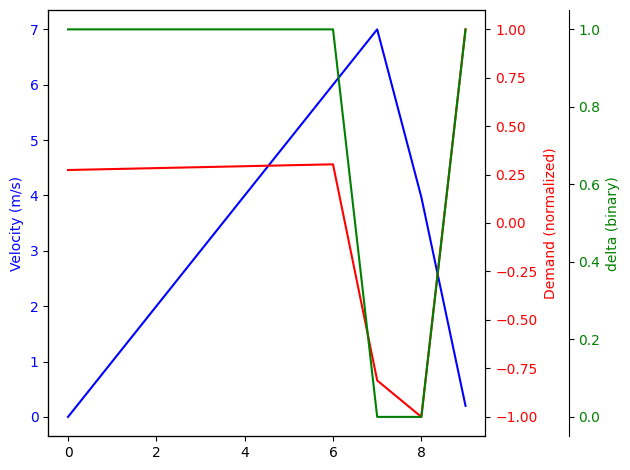

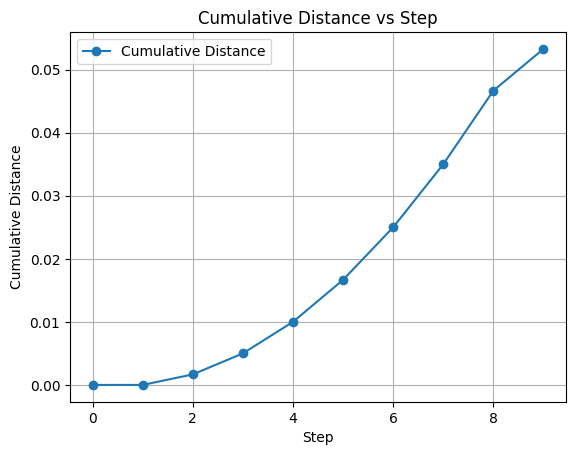

In [26]:
fig, ax1 = plt.subplots()

ax1.plot(v_sol, 'b-', label='Velocity (km/h)')
ax1.set_ylabel('Velocity (m/s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(d_sol, 'r-', label='Demand (normalized)')
ax2.set_ylabel('Demand (normalized)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(delta_sol, 'g-', label='delta (binary)')
ax3.set_ylabel('delta (binary)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

fig.tight_layout()
plt.show()

# Plot Dists vs index
plt.figure()
plt.plot(Dists, marker='o', label='Cumulative Distance')
plt.xlabel('Step')
plt.ylabel('Cumulative Distance')
plt.title('Cumulative Distance vs Step')
plt.grid(True)
plt.legend()
plt.show()

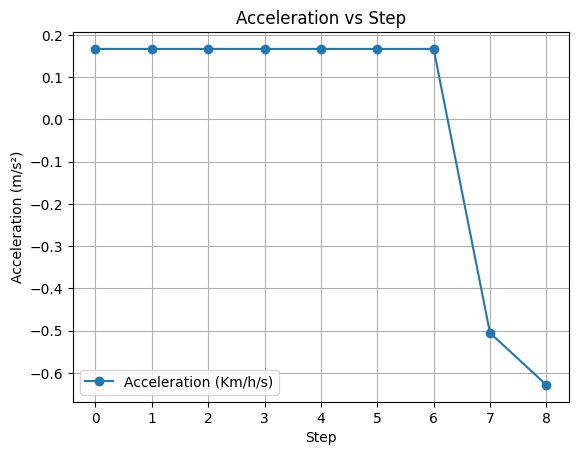

[0.1666666666666667, 0.1666666666666667, 0.16666666666666682, 0.16666666666666674, 0.16666666666666682, 0.16666666666666682, 0.16666666666666696, -0.50509822085283, -0.6282351124805042]


In [27]:
acceleration = []
for i in range(0, N-1):
    acceleration.append((v_sol[i+1] - v_sol[i]) / (dt))

plt.figure()
plt.plot(acceleration, marker='o', label='Acceleration (Km/h/s)')
plt.xlabel('Step')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration vs Step')
plt.grid(True)
plt.legend()
plt.show()
print(acceleration)

In [28]:
df = pd.DataFrame({
    'Step': range(len(v_sol)),
    'Speed': v_sol,
    'Normalized Demand': d_sol,
    'Delta Indicator': delta_sol
})

df

,Step,Speed,Normalized Demand,Delta Indicator
0,0,0.000000,0.273173,1.0
1,1,1.000000,0.278069,1.0
2,2,2.000000,0.282966,1.0
3,3,3.000000,0.287862,1.0
4,4,4.000000,0.292758,1.0
5,5,5.000000,0.297655,1.0
6,6,6.000000,0.302551,1.0
7,7,7.000000,-0.811972,0.0
8,8,3.969411,-1.000000,0.0
9,9,0.200000,0.998400,1.0


In [29]:
import logging
import numpy as np
from docplex.mp.model_reader import ModelReader
from qiskit.algorithms.minimum_eigensolvers import QAOA, SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import CobylaOptimizer, CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer

import matplotlib.pyplot as plt

import numpy as np
from docplex.mp.basic import Expr
from docplex.mp.model import Model
from docplex.mp.solution import SolveSolution
from docplex.util.status import JobSolveStatus
import cplex.callbacks as cpx_cb
from docplex.mp.callbacks.cb_mixin import ModelCallbackMixin
from docplex.mp.model import Model
from docplex.mp.relax_linear import LinearRelaxer

from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import IntegerToBinary
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.translators import from_docplex_mp

from qiskit_optimization.algorithms import MinimumEigenOptimizer


from qiskit.algorithms.minimum_eigensolvers import QAOA, SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import CobylaOptimizer, CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer

from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo, QuadraticProgramConverter
from qiskit_optimization.converters import InequalityToEquality



import cvxpy as cp
import numpy as np
import sys
from typing import List, Callable, Union

/var/folders/_c/3wtfy9817z34rvv08pv6h2rm0000gn/T/ipykernel_1681/3936853193.py:4: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import QAOA, SamplingVQE, NumPyMinimumEigensolver


In [30]:
from docplex.mp.model_reader import ModelReader
import numpy as np

model = ModelReader.read('mip_model.lp')

Problem name: mip_model

Minimize
  -0.28661556732*v_0 - 0.28661556732*v_1 - 0.28661556732*v_2 - 0.28661556732*v_3
  - 0.28661556732*v_4 - 0.28661556732*v_5 - 0.28661556732*v_6
  - 0.28661556732*v_7 - 0.28661556732*v_8 - 0.28661556732*v_9
  + 0.024674505091*w1_0 + 0.024674505091*w1_1 + 0.024674505091*w1_2
  + 0.024674505091*w1_3 + 0.024674505091*w1_4 + 0.024674505091*w1_5
  + 0.024674505091*w1_6 + 0.024674505091*w1_7 + 0.024674505091*w1_8
  + 0.024674505091*w1_9

Subject to
  Linear constraints (181)
    c_0 >= 1  'c1'
    -250*c_0 - 2*v_0 + w1_0 >= -500  'c2'
    -2*v_0 + w1_0 <= 0  'c3'
    -250*c_0 + w1_0 <= 0  'c4'
    -250*c_1 - 2*v_1 + w1_1 >= -500  'c5'
    -2*v_1 + w1_1 <= 0  'c6'
    -250*c_1 + w1_1 <= 0  'c7'
    -250*c_2 - 2*v_2 + w1_2 >= -500  'c8'
    -2*v_2 + w1_2 <= 0  'c9'
    -250*c_2 + w1_2 <= 0  'c10'
    -250*c_3 - 2*v_3 + w1_3 >= -500  'c11'
    -2*v_3 + w1_3 <= 0  'c12'
    -250*c_3 + w1_3 <= 0  'c13'
    -250*c_4 - 2*v_4 + w1_4 >= -500  'c14'
    -2*v_4 + w1_4 <=

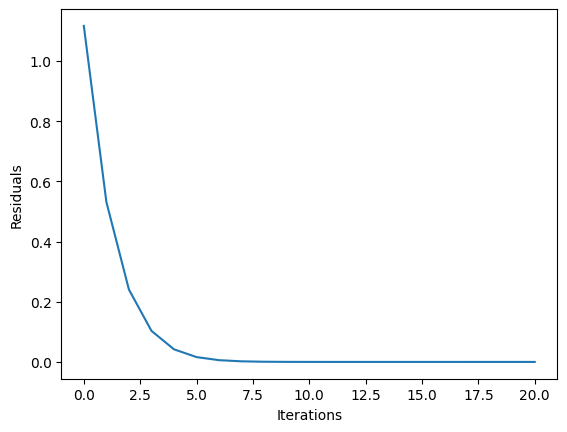

In [43]:
admm_params = ADMMParameters(
    rho_initial=100001, beta=100000, factor_c=90000, maxiter=100, three_block=True, tol=1.0e-6
)

cobyla = CobylaOptimizer()
cplex = CplexOptimizer()

# define QAOA via the minimum eigen optimizer
qaoa = MinimumEigenOptimizer(QAOA(reps=1, sampler=Sampler(), optimizer=COBYLA(maxiter=200)))

exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())  # to solve QUBOs

# define QUBO optimizer
#qubo_optimizer = exact
qubo_optimizer = cplex  # uncomment to use CPLEX instead

# define classical optimizer
convex_optimizer = cplex #cobyla
# convex_optimizer = cplex  # uncomment to use CPLEX instead

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(
    params=admm_params, qubo_optimizer=qubo_optimizer, continuous_optimizer=convex_optimizer
)
# load quadratic program from docplex model
qp = from_docplex_mp(model)
print(qp.prettyprint())

# run ADMM to solve problem
result_admm = admm.solve(qp)

print(result_admm.prettyprint())
# print(result)
plt.plot(result_admm.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()


In [44]:
result_admm

<ADMMOptimizationResult: fval=-8.598466688969234, v_0=0.0, v_1=0.9999999999972631, v_2=1.9999999999916527, v_3=2.9999999999837197, v_4=3.9999999999398073, v_5=4.79687525275961, v_6=5.327792087979299, v_7=5.592750505711113, v_8=4.082582147746733, v_9=0.1999999999992308, c_0=1.2731730465808533, c_1=1.273384641009292, c_2=1.274632553927514, c_3=1.2754352830971605, c_4=1.222665205786882, c_5=1.1536269882793793, c_6=1.0844123439293964, c_7=0.6197233260486943, c_8=4.831011452905302e-12, c_9=0.7925897729513016, w1_0=0.0, w1_1=1.6663307138291169e-06, w1_2=1.6663414990514195e-06, w1_3=1.6663450962860495e-06, w1_4=1.6663468727678246e-06, w1_5=1.6663477418229322e-06, w1_6=1.666348164096639e-06, w1_7=1.6663481692008613e-06, w1_8=6.037662155912469e-10, w1_9=1.6662442023517155e-06, delta_0=0.0, delta_1=0.0, delta_2=0.0, delta_3=0.0, delta_4=0.0, delta_5=0.0, delta_6=0.0, delta_7=0.0, delta_8=0.0, delta_9=0.0, z1_0=255027.60077727516, z2_0=1.8960316511847195e-07, z1_1=253977.59905253904, z2_1=6.62505

In [45]:
result_admm.fval

-8.598466688969234

In [46]:
# Here we solve the model

# result = opt_model.solve(log_output=True)
if result_admm:
    v_sol = [result_admm[f"v_{i}"] for i in range(N)]
    d_sol = [result_admm[f"c_{i}"]-1 for i in range(N)]
    delta_sol = [result_admm[f"delta_{i}"] for i in range(N)]
    print("Solution found")
else:
    print("No solution found.")

Dists = []
for i in range(0, N):
    dist_temp = sum(v_sol[:i])/3600
    Dists.append(dist_temp*dt)

Solution found


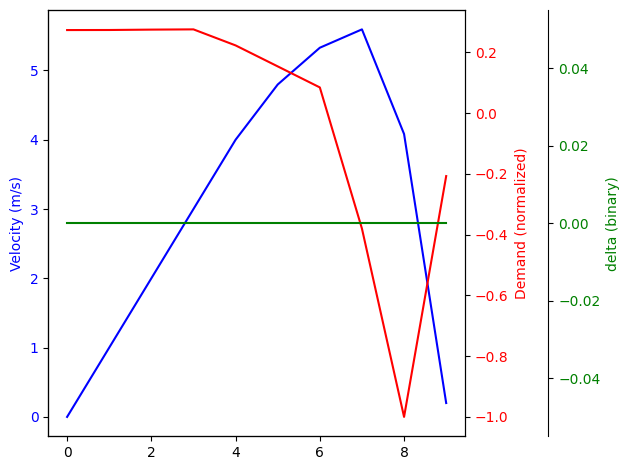

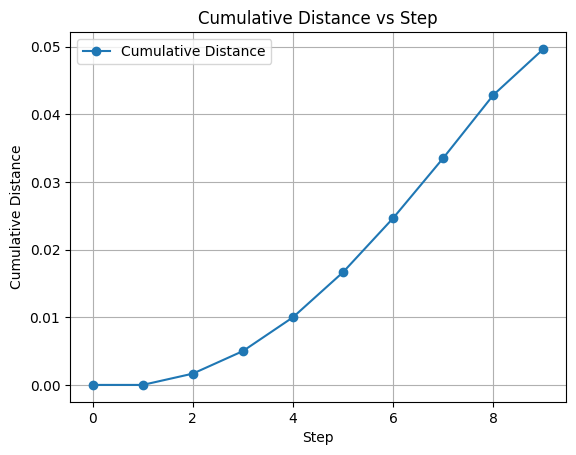

In [47]:
fig, ax1 = plt.subplots()

ax1.plot(v_sol, 'b-', label='Velocity (km/h)')
ax1.set_ylabel('Velocity (m/s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(d_sol, 'r-', label='Demand (normalized)')
ax2.set_ylabel('Demand (normalized)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(delta_sol, 'g-', label='delta (binary)')
ax3.set_ylabel('delta (binary)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

fig.tight_layout()
plt.show()

# Plot Dists vs index
plt.figure()
plt.plot(Dists, marker='o', label='Cumulative Distance')
plt.xlabel('Step')
plt.ylabel('Cumulative Distance')
plt.title('Cumulative Distance vs Step')
plt.grid(True)
plt.legend()
plt.show()

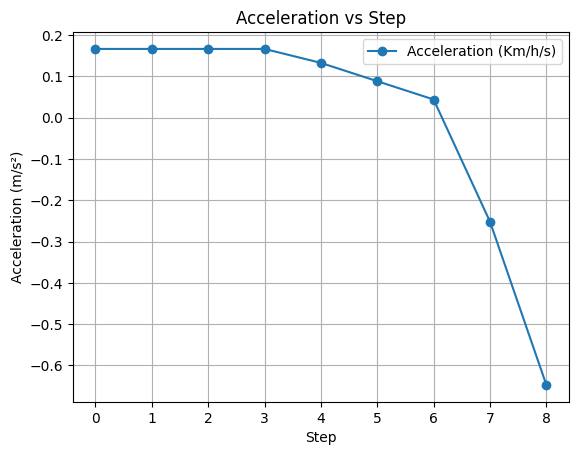

[0.16666666666621052, 0.1666666666657316, 0.1666666666653445, 0.16666666665934793, 0.13281254213663374, 0.08848613920328156, 0.0441597362886356, -0.2516947263273967, -0.6470970246245836]


In [48]:
acceleration = []
for i in range(0, N-1):
    acceleration.append((v_sol[i+1] - v_sol[i]) / (dt))

plt.figure()
plt.plot(acceleration, marker='o', label='Acceleration (Km/h/s)')
plt.xlabel('Step')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration vs Step')
plt.grid(True)
plt.legend()
plt.show()
print(acceleration)

In [49]:
df = pd.DataFrame({
    'Step': range(len(v_sol)),
    'Speed': v_sol,
    'Normalized Demand': d_sol,
    'Delta Indicator': delta_sol
})

df

,Step,Speed,Normalized Demand,Delta Indicator
0,0,0.000000,0.273173,0.0
1,1,1.000000,0.273385,0.0
2,2,2.000000,0.274633,0.0
3,3,3.000000,0.275435,0.0
4,4,4.000000,0.222665,0.0
5,5,4.796875,0.153627,0.0
6,6,5.327792,0.084412,0.0
7,7,5.592751,-0.380277,0.0
8,8,4.082582,-1.000000,0.0
9,9,0.200000,-0.207410,0.0
